In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [24]:
#Size of our input images
SIZE = 128

#Define generators for training, validation and also anomaly data.
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_dir = r'cell_images\Uninfected'

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    subset='training'
    )

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    subset='validation'
    )

anomaly_generator = datagen.flow_from_directory(
    'cell_images/Parasitized',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 11024 images belonging to 1 classes.
Found 2755 images belonging to 1 classes.
Found 13779 images belonging to 1 classes.


In [25]:
#Define the autoencoder. 
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

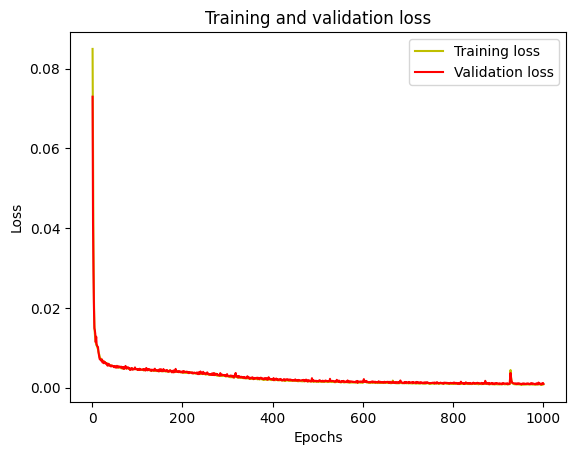

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model.save('image_anomaly_model.keras')

2/2 [==============================] - 1s 150ms/step


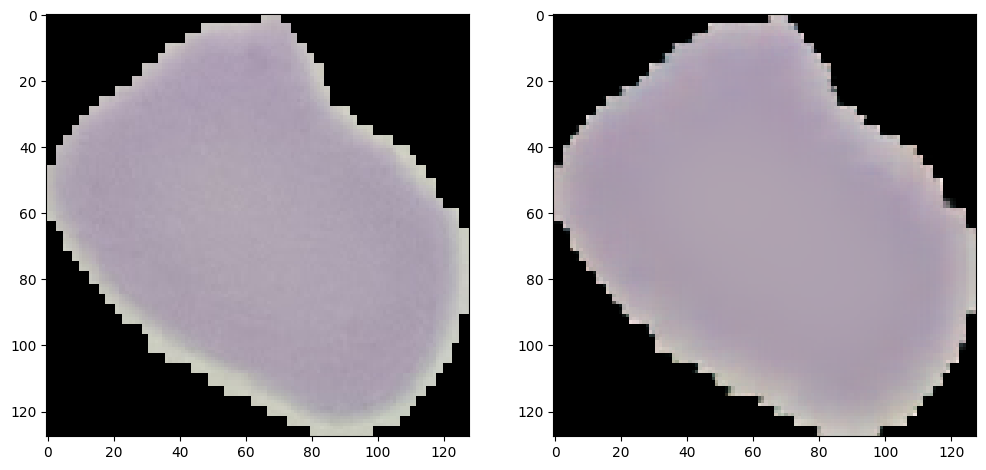

In [28]:
# Get all batches generated by the datagen and pick a batch for prediction
# Just to test the model by train dataset. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

### Examine the reconstruction error between our validation data (good/normal images) and the anomaly images

In [29]:
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\106648825.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\106648825.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.0009832754731178284, 0.0009832754731178284]
Recon. error for the anomaly data is:  [0.001368061639368534, 0.001368061639368534]


### encoder_model and KDE way

In [30]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 16)      

In [31]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\3483831194.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018


In [32]:
print("The validation (normal/uninfected) data is: ")
print("average density, stdev density, average recon error, stdev recon error: ", uninfected_values)
print("The anomaly data is: ")
print("average density, stdev density, average recon error, stdev recon error: ", anomaly_values)

The validation (normal/uninfected) data is: 
average density, stdev density, average recon error, stdev recon error:  (2818.977627330485, 4.549277703940135e-12, 0.0015452986879695562, 0.000911271333798164)
The anomaly data is: 
average density, stdev density, average recon error, stdev recon error:  (260.0304829468273, 4046.1212290628882, 0.002905996961681734, 0.0019639574935008414)


### Validation and Testing

1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\3091407326.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022
2792.2944312829586 0.002216014312580228
The image is normal
1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\3091407326.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0039 - mse: 0.0039
137.47455881321514 0.003916561603546143
The image is an anomaly


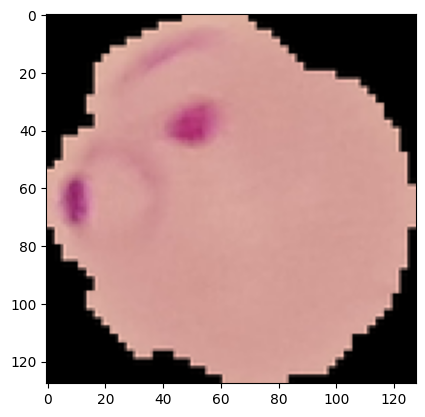

In [46]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    print(density, reconstruction_error)

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is normal")
        
        
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob(r'cell_images\Parasitized\Parasitized\*')
uninfected_file_paths = glob.glob(r'cell_images\Uninfected\Uninfected\*')

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

In [58]:
#Now, input unknown images and sort as Good or Anomaly
normal_count = 0
normal_false_result = []
anomaly_count = 0
anomaly_false_result = []

def check_anomaly_calc(img_path, label): # label = normal or anomaly
    global normal_count
    global normal_false_result
    global anomaly_count 
    global anomaly_false_result
    
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if label == 'anomaly': 
        if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
            anomaly_count += 1
        else:
            anomaly_false_result.append([density, reconstruction_error])
    else:   
        if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
            normal_false_result.append([density, reconstruction_error])
        else:
            normal_count += 1
        
        
        
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob(r'cell_images\Parasitized\Parasitized\*')
uninfected_file_paths = glob.glob(r'cell_images\Uninfected\Uninfected\*')

1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0084 - mse: 0.0084


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0057 - mse: 0.0057


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0053 - mse: 0.0053


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0046 - mse: 0.0046


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - mse: 0.0033


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step - loss: 0.0048 - mse: 0.0048


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step - loss: 0.0039 - mse: 0.0039


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0064

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0056 - mse: 0.0056


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0052 - mse: 0.0052


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0086 - mse: 0.0086

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step - loss: 0.0038 - mse: 0.0038


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 7ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step - loss: 0.0041 - mse: 0.0041


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0062 - mse: 0.0062


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step - loss: 0.0040 - mse: 0.0040


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0052

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0060

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0085 - mse: 0.0085


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 8ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step - loss: 0.0063 - mse: 0.0063


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step - loss: 0.0044 - mse: 0.0044


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0047 - mse: 0.0047

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0043 - mse: 0.0043


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0049 - mse: 0.0049


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0068

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0064 - mse: 0.0064


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 7ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step - loss: 0.0045 - mse: 0.0045


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 7ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step - loss: 0.0038 - mse: 0.0038


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step - loss: 0.0063 - mse: 0.0063


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0060

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step - loss: 0.0082 - mse: 0.0082


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0063

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0063 - mse: 0.0063


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step - loss: 0.0057 - mse: 0.0057


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 6ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0082

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0047 - mse: 0.0047

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0052 - mse: 0.0052


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step - loss: 0.0047 - mse: 0.0047


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0043 - mse: 0.0043


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0056 - mse: 0.0056


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0052 - mse: 0.0052


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0039 - mse: 0.0039


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step - loss: 0.0049 - mse: 0.0049


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step - loss: 0.0055 - mse: 0.0055


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0058 - mse: 0.0058

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0058 - mse: 0.0058

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step - loss: 0.0037 - mse: 0.0037


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step - loss: 0.0055 - mse: 0.0055


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0054

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step - loss: 0.0069 - mse: 0.0069


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 6ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 8ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0053 - mse: 0.0053

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0052

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0068

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0052

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0069 - mse: 0.0069


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0056 - mse: 0.0056


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0065

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step - loss: 0.0046 - mse: 0.0046


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step - loss: 0.0044 - mse: 0.0044


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0051 - mse: 0.0051

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step - loss: 0.0050 - mse: 0.0050


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0065

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0056 - mse: 0.0056

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0056 - mse: 0.0056


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0065 - mse: 0.0065


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0037 - mse: 0.0037


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0067

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step - loss: 0.0024 - mse: 0.0024


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 7ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 8ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0020 - mse: 0.0020


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0062 - mse: 0.0062


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0060 - mse: 0.0060


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step - loss: 0.0033 - mse: 0.0033


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 7ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 7ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 8ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 8ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0036 - mse: 0.0036


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0030 - mse: 0.0030


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0031 - mse: 0.0031


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0030 - mse: 0.0030


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0021 - mse: 0.0021


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0031 - mse: 0.0031


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0029 - mse: 0.0029


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0022 - mse: 0.0022


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0018 - mse: 0.0018


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0021 - mse: 0.0021


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step - loss: 0.0013 - mse: 0.0013


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0024 - mse: 0.0024


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0018 - mse: 0.0018


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0032 - mse: 0.0032


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0034 - mse: 0.0034


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0034 - mse: 0.0034


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0023 - mse: 0.0023


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0022 - mse: 0.0022


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0023 - mse: 0.0023


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0029 - mse: 0.0029


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0052 - mse: 0.0052


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0023 - mse: 0.0023


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0022 - mse: 0.0022


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0020 - mse: 0.0020


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0043 - mse: 0.0043


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0023 - mse: 0.0023


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0039 - mse: 0.0039


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0030 - mse: 0.0030


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0029 - mse: 0.0029


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0037 - mse: 0.0037


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0025 - mse: 0.0025


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step - loss: 0.0033 - mse: 0.0033


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - mse: 0.0029


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0022 - mse: 0.0022


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0025 - mse: 0.0025


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0054

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 8ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 10ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0059 - mse: 0.0059

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0066

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 11ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 9ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 13ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 15ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 12ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step - loss: 0.0042 - mse: 0.0042


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 126ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 114ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 14ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 16ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 18ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 17ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 20ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 91ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 105ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 170ms/step - loss: 0.0040 - mse: 0.0040


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 100ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 94ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 111ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 96ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 91ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 92ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 107ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 91ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 96ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 50ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 102ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 96ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 100ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 336ms/step - loss: 0.0024 - mse: 0.0024


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 416ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 380ms/step - loss: 0.0045 - mse: 0.0045


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 377ms/step - loss: 0.0023 - mse: 0.0023


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 347ms/step - loss: 0.0037 - mse: 0.0037


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 345ms/step - loss: 0.0053 - mse: 0.0053


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 320ms/step - loss: 0.0029 - mse: 0.0029


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 277ms/step - loss: 0.0031 - mse: 0.0031


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 367ms/step - loss: 0.0039 - mse: 0.0039


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 315ms/step - loss: 0.0026 - mse: 0.0026


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 267ms/step - loss: 0.0032 - mse: 0.0032


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 288ms/step - loss: 0.0034 - mse: 0.0034


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 275ms/step - loss: 0.0032 - mse: 0.0032


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 336ms/step - loss: 0.0044 - mse: 0.0044


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 307ms/step - loss: 0.0039 - mse: 0.0039


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 330ms/step - loss: 0.0033 - mse: 0.0033


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 347ms/step - loss: 0.0021 - mse: 0.0021


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 358ms/step - loss: 0.0038 - mse: 0.0038


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 92ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 292ms/step - loss: 0.0030 - mse: 0.0030


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 406ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 339ms/step - loss: 0.0031 - mse: 0.0031


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 299ms/step - loss: 0.0035 - mse: 0.0035


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 464ms/step - loss: 0.0046 - mse: 0.0046


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 439ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 402ms/step - loss: 0.0017 - mse: 0.0017


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 400ms/step - loss: 0.0027 - mse: 0.0027


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 93ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 52ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 94ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 57ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 101ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 93ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 53ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 58ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 91ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 107ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 102ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 113ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 228ms/step - loss: 0.0028 - mse: 0.0028


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 96ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 104ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 99ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 92ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 99ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s

C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 101ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 111ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 97ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 61ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 99ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 111ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 94ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 54ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 90ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 64ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 73ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 75ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 94ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 92ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 119ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 100ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 108ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 67ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 66ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 91ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 72ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 87ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 74ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 71ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 62ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 125ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 65ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 69ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 76ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 78ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 70ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 68ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 63ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 86ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 127ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 79ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 107ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 99ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 108ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 91ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 105ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 94ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 85ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 77ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 88ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 80ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 96ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 82ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 120ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 104ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 81ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 93ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 95ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 89ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 83ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 84ms/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_24512\1355587075.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


KeyboardInterrupt: 

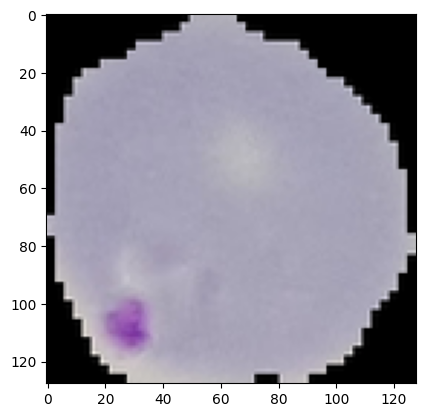

In [59]:
#Anomaly image verification
for filename in para_file_paths:
    check_anomaly_calc(filename, 'anomaly')

print("Anomaly result accuracy: {}".format(anomaly_count/len(para_file_paths)))

In [ ]:
#Good/normal image verification
for filename in uninfected_file_paths:
    check_anomaly_calc(filename, 'normal')

print("Normal result accuracy: {}".format(normal_count/len(uninfected_file_paths)))